In [1]:
!pip install py4j

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from pyspark import SparkConf, SparkContext, SQLContext

In [3]:
# Configure spark context settings and initialize SQL context
conf = (SparkConf()
         .setAppName("s3a_test")
         .set("spark.executor.instances", "8")
         .set("spark.executor.cores", 2)
         .set("spark.shuffle.compress", "true")
         .set("spark.io.compression.codec", "snappy")
         .set("spark.executor.memory", "2g"))

sc = SparkContext(conf = conf)

sqlContext = SQLContext(sc)

## Load Data, Manage Format for Regression

In [185]:
# READ DATA FILE
df = sqlContext.read.load("total.json")

In [186]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- PLocationID: integer (nullable = true)
 |-- features: vector (nullable = true)



In [187]:
df.count()

4230796

In [383]:
# Work on random sample of the data
data = df.sample(False, 0.01, seed=None)

In [384]:
data.count()

42485

## Split Training and Testing

In [385]:
training, testing = data.randomSplit([0.7, 0.3])

In [386]:
import numpy as np

# Convert to numpy array
X_train = np.array(training.select('features').collect()).squeeze()
X_test = np.array(testing.select('features').collect()).squeeze()

# Drop last column from X_train and X_test - this column accidentally contains the label
X_train = X_train[:,0:-1]
X_test = X_test[:,0:-1]

## Transform Labels to Binary (Within Neighborhood or Not)

In [387]:
y_train_full_df = training.select('label').collect()
y_test_full_df = testing.select('label').collect()

y_train_ID = training.select('PLocationID').collect()
y_test_ID = testing.select('PLocationID').collect()

In [388]:
y_train_full_np = np.array(y_train_full_df).squeeze()
y_test_full_np = np.array(y_test_full_df).squeeze()

y_train_ID_np = np.array(y_train_ID).squeeze()
y_test_ID_np = np.array(y_test_ID).squeeze()

In [389]:
# Extract pickup districts
map_dict = {4: 1, 12: 2,13: 2,24: 3,41: 4,42: 4,43: 5,45: 1,48: 6,50: 6,68: 6,74: 7,75: 7,79: 1,87: 2,88: 2,90: 8,\
            100: 8,103: 2,104: 2,105: 2,107: 9,113: 10,114: 10,116: 11,120: 12,125: 10,127: 12,128: 12,137: 9,140: 11,\
            141: 11,142: 3,143: 3,144: 1,148: 1,151: 3,152: 11,153: 12,158: 6,161: 8,162: 8,163: 8,164: 8,166: 11,\
            170: 9,186: 8,194: 7,202: 13,209: 2,211: 10,224: 9,229: 9,230: 8,231: 2,232: 1,233: 9,234: 10,236: 13,\
            237: 13,238: 3,239: 3,243: 12,244: 12,246: 6,249: 10,261: 2,262: 13,263: 13}
mapper = lambda x: map_dict[x]
mapper_vect = np.vectorize(mapper)

In [390]:
y_train = np.array(y_train_full_np == mapper_vect(y_train_ID_np)).astype(int)
y_test = np.array(y_test_full_np == mapper_vect(y_test_ID_np)).astype(int)

## Balance Dataset: 50% Within, 50% Out of Neighborhood

In [391]:
# Split data into one-labeled and zero-labeled groups
X_train_ones = X_train[y_train.astype(bool)]
X_train_zeros = X_train[np.array(y_train == 0)]

In [392]:
# Select equal number of zero-labeled observations as one-labeled
num_ones = X_train_ones.shape[0]
X_train_zeros = X_train_zeros[0:num_ones,:]

In [393]:
# Concatenate X_train_ones and X_train_zeros to form new training dataset
X_train = np.concatenate((X_train_ones, X_train_zeros))

In [394]:
# Relabel appropriately
y_train = np.concatenate((np.ones(num_ones), np.zeros(num_ones)))

In [395]:
# Shuffle training data and labels with same vertices
new_idx = np.arange(num_ones*2)
np.random.shuffle(new_idx)

X_train = X_train[new_idx]
y_train = y_train[new_idx]

## Logistic Regression

In [396]:
from sklearn.linear_model import LogisticRegression

# Initialize Model
lr = LogisticRegression()

# Fit training data
model = lr.fit(X_train, y_train)

# Predict labels on test data
preds = model.predict(X_test)

In [397]:
# Accuracy
np.sum(preds == y_test) / preds.shape[0]

0.56928750784682991

In [398]:
# Exhaustive Parameter Search
from sklearn.model_selection import GridSearchCV
# lr_params = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} #, 'penalty':['l1','l2']}
lr_params = {'penalty':['l1','l2'], 'fit_intercept':[True, False]}
lr = LogisticRegression(solver='liblinear')
clf = GridSearchCV(lr, lr_params)

In [399]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [400]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_fit_intercept', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [401]:
clf.cv_results_['mean_test_score']

array([ 0.58135115,  0.58263855,  0.58135115,  0.58110593])

## Random Forest

In [301]:
# Start with default tree
from sklearn import tree

decTree = tree.DecisionTreeClassifier()
model = decTree.fit(X_train, y_train)
pred = model.predict(X_test)

In [302]:
# Accuracy
np.sum(preds == y_test) / preds.shape[0]

0.55621771950734999

In [303]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=100, verbose=1)
model = RFC.fit(X_train, y_train)
pred = model.predict(X_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [304]:
# Accuracy
np.sum(preds == y_test) / preds.shape[0]

0.55621771950734999

In [338]:
# Exhaustive Hyperparameter Search
rfc_params = {'n_estimators':[50, 100, 120, 150], 'min_samples_split':[10, 20, 50, 75, 100, 150]}
rfc = RandomForestClassifier()
rfc_search = GridSearchCV(rfc, rfc_params)

In [339]:
rfc_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 120, 150], 'min_samples_split': [10, 20, 50, 75, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [340]:
rfc_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [341]:
rfc_search.cv_results_['params']

[{'min_samples_split': 10, 'n_estimators': 50},
 {'min_samples_split': 10, 'n_estimators': 100},
 {'min_samples_split': 10, 'n_estimators': 120},
 {'min_samples_split': 10, 'n_estimators': 150},
 {'min_samples_split': 20, 'n_estimators': 50},
 {'min_samples_split': 20, 'n_estimators': 100},
 {'min_samples_split': 20, 'n_estimators': 120},
 {'min_samples_split': 20, 'n_estimators': 150},
 {'min_samples_split': 50, 'n_estimators': 50},
 {'min_samples_split': 50, 'n_estimators': 100},
 {'min_samples_split': 50, 'n_estimators': 120},
 {'min_samples_split': 50, 'n_estimators': 150},
 {'min_samples_split': 75, 'n_estimators': 50},
 {'min_samples_split': 75, 'n_estimators': 100},
 {'min_samples_split': 75, 'n_estimators': 120},
 {'min_samples_split': 75, 'n_estimators': 150},
 {'min_samples_split': 100, 'n_estimators': 50},
 {'min_samples_split': 100, 'n_estimators': 100},
 {'min_samples_split': 100, 'n_estimators': 120},
 {'min_samples_split': 100, 'n_estimators': 150},
 {'min_samples_split'

In [342]:
rfc_search_train = rfc_search.cv_results_['mean_train_score']

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [343]:
rfc_search_test = rfc_search.cv_results_['mean_test_score']

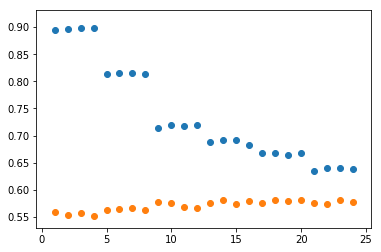

In [365]:
plt.scatter(np.array(range(1,len(rfc_search_train)+1)),rfc_search_train)
# plt.legend("Training Accuracy", fontsize=12)
plt.scatter(np.array(range(1,len(rfc_search_test)+1)),rfc_search_test)
# plt.legend("Testing Accuracy", fontsize=12)

## Boosting

In [366]:
from sklearn.ensemble import AdaBoostClassifier

adaBoost = AdaBoostClassifier(n_estimators=20)
model = adaBoost.fit(X_train, y_train)
pred = adaBoost.predict(X_test)

In [367]:
# Accuracy
np.sum(pred == y_test) / pred.shape[0]

0.56177989670242356

In [378]:
# Hyperparameter Search
adaB_params = {'n_estimators':[20, 30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate':[0.01, 0.05, 0.1]}
adaB_class = AdaBoostClassifier()
adaB_search = GridSearchCV(adaB_class, adaB_params)
adaB_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate': [0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [379]:
adaB_search_train = adaB_search.cv_results_['mean_train_score']
adaB_search.cv_results_['mean_train_score']

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([ 0.5730789 ,  0.57620292,  0.57620292,  0.57620292,  0.57620292,
        0.57620292,  0.57620292,  0.57620292,  0.57854375,  0.57854375,
        0.58057436,  0.58198003,  0.58213623,  0.58385415,  0.58494697,
        0.58900835,  0.59119487,  0.59291294,  0.58166763,  0.58291738,
        0.58619673,  0.59509932,  0.59931631,  0.60072095,  0.60212647,
        0.60400001,  0.60712242])

In [380]:
adaB_search.cv_results_['params']

[{'learning_rate': 0.01, 'n_estimators': 20},
 {'learning_rate': 0.01, 'n_estimators': 30},
 {'learning_rate': 0.01, 'n_estimators': 40},
 {'learning_rate': 0.01, 'n_estimators': 50},
 {'learning_rate': 0.01, 'n_estimators': 60},
 {'learning_rate': 0.01, 'n_estimators': 70},
 {'learning_rate': 0.01, 'n_estimators': 80},
 {'learning_rate': 0.01, 'n_estimators': 90},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.05, 'n_estimators': 20},
 {'learning_rate': 0.05, 'n_estimators': 30},
 {'learning_rate': 0.05, 'n_estimators': 40},
 {'learning_rate': 0.05, 'n_estimators': 50},
 {'learning_rate': 0.05, 'n_estimators': 60},
 {'learning_rate': 0.05, 'n_estimators': 70},
 {'learning_rate': 0.05, 'n_estimators': 80},
 {'learning_rate': 0.05, 'n_estimators': 90},
 {'learning_rate': 0.05, 'n_estimators': 100},
 {'learning_rate': 0.1, 'n_estimators': 20},
 {'learning_rate': 0.1, 'n_estimators': 30},
 {'learning_rate': 0.1, 'n_estimators': 40},
 {'learning_rate': 0.1, 'n_estimato

In [381]:
adaB_search_test = adaB_search.cv_results_['mean_test_score']
adaB_search.cv_results_['mean_test_score']

array([ 0.57307933,  0.57058089,  0.57058089,  0.57058089,  0.57058089,
        0.57058089,  0.57058089,  0.57058089,  0.56964397,  0.56964397,
        0.57183011,  0.57183011,  0.57214241,  0.57276702,  0.57058089,
        0.5715178 ,  0.56901936,  0.56777014,  0.57183011,  0.57214241,
        0.56933167,  0.56839475,  0.56527171,  0.56620862,  0.56683323,
        0.56652092,  0.56745784])

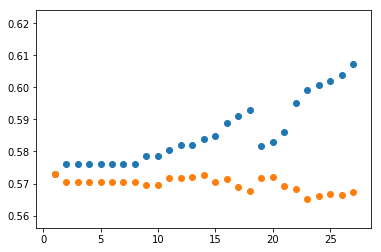

In [382]:
plt.scatter(np.array(range(1,len(adaB_search_train)+1)),adaB_search_train)
# plt.legend("Training Accuracy", fontsize=12)
plt.scatter(np.array(range(1,len(adaB_search_test)+1)),adaB_search_test)
# plt.legend("Testing Accuracy", fontsize=12)

## Multilayer Perceptron

In [430]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [473]:
mlpc = MLPClassifier(verbose=True, activation='tanh', learning_rate_init=0.0001, learning_rate='adaptive')
model = mlpc.fit(X_train, y_train)
pred = model.predict(X_test)

Iteration 1, loss = 0.73164897
Iteration 2, loss = 0.68650132
Iteration 3, loss = 0.67515679
Iteration 4, loss = 0.67099230
Iteration 5, loss = 0.66874776
Iteration 6, loss = 0.66735666
Iteration 7, loss = 0.66614110
Iteration 8, loss = 0.66484037
Iteration 9, loss = 0.66435727
Iteration 10, loss = 0.66342747
Iteration 11, loss = 0.66211416
Iteration 12, loss = 0.66134895
Iteration 13, loss = 0.66037063
Iteration 14, loss = 0.65963037
Iteration 15, loss = 0.65888059
Iteration 16, loss = 0.65787774
Iteration 17, loss = 0.65732503
Iteration 18, loss = 0.65629288
Iteration 19, loss = 0.65565573
Iteration 20, loss = 0.65509732
Iteration 21, loss = 0.65438131
Iteration 22, loss = 0.65347422
Iteration 23, loss = 0.65285309
Iteration 24, loss = 0.65206536
Iteration 25, loss = 0.65153035
Iteration 26, loss = 0.65057362
Iteration 27, loss = 0.65008276
Iteration 28, loss = 0.64934178
Iteration 29, loss = 0.64847292
Iteration 30, loss = 0.64784713
Iteration 31, loss = 0.64743473
Iteration 32, los

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [474]:
# Accuracy
np.sum(pred == y_test) / pred.shape[0]

0.54252981795354682

In [475]:
pred = model.predict(X_train)

In [476]:
# Training Accuracy
np.sum(pred == y_train) / pred.shape[0]

0.7343060323688082